In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable

import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
num_epochs = 5
learning_rate = 0.001
batch_size = 100

In [4]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

In [5]:
class FashionDataset(Dataset):    
    def __init__(self, data, transform = None):
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [6]:
train_set = FashionDataset(train_df, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_df, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size)

In [7]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [8]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [9]:
len(train_set)

60000

In [10]:
len(test_set)

10000

Pullover


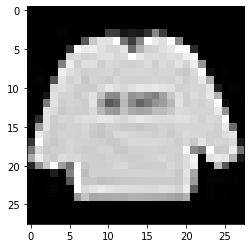

In [11]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

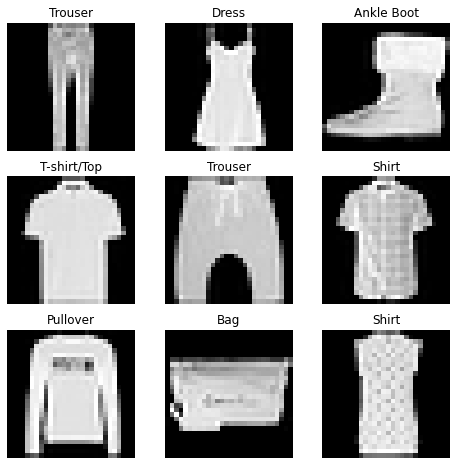

In [12]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(output_label(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [13]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [14]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [15]:
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = error(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
            
        if not (count % 50):  
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {:.2f}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5320762395858765, Accuracy: 87.43%
Iteration: 1000, Loss: 0.2944447994232178, Accuracy: 88.16%
Iteration: 1500, Loss: 0.22417189180850983, Accuracy: 90.15%
Iteration: 2000, Loss: 0.1743464469909668, Accuracy: 90.51%
Iteration: 2500, Loss: 0.20372778177261353, Accuracy: 91.58%
Iteration: 3000, Loss: 0.21575425565242767, Accuracy: 91.40%
